In [44]:
# Sequential Data
# Crypto Price Prediction

In [45]:
pip install requests_cache

In [46]:
pip install matplotlib pandas-datareader pandas numpy

In [47]:
pip install tensorflow scikit-learn

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import requests_cache

In [49]:
from sklearn.preprocessing import MinMaxScaler # to scale the finance data between 0 and 1 or -1 and 1 for the neural network

In [50]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [51]:
# LSTM -> Long Short Term Memory, a recurrent layer for the sequential data

In [52]:
# Get the financial data

In [53]:
crypto_currency = 'ETH'
against_currency = 'INR'

# Time Frame for the Training
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after='expire_after')
# just add headers to your session and provide it to the reader
session.headers = {     'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',     'Accept': 'application/json;charset=utf-8'     }


# Get the actual data
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end, session=session)

In [54]:
# Prepare Data
print(data.tail())

                    High           Low  ...        Volume     Adj Close
Date                                    ...                            
2021-12-15  311815.81250  279921.40625  ...  2.012840e+12  306248.00000
2021-12-16  313384.78125  301323.96875  ...  1.510066e+12  301812.40625
2021-12-17  304133.96875  282232.87500  ...  1.760124e+12  295044.65625
2021-12-18  303736.75000  287068.90625  ...  1.485354e+12  301229.34375
2021-12-19  305625.00000  297174.68750  ...  1.335378e+12  303301.43750

[5 rows x 6 columns]


In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [56]:
prediction_days = 60

In [57]:
# Prepare the training data
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [58]:
# Create Neural Network
# Dropout Layer is to prevent overfitting
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
24/24 [==============================] - 9s 171ms/step - loss: 0.0313
Epoch 2/25
24/24 [==============================] - 4s 171ms/step - loss: 0.0067
Epoch 3/25
24/24 [==============================] - 4s 176ms/step - loss: 0.0054
Epoch 4/25
24/24 [==============================] - 4s 185ms/step - loss: 0.0051
Epoch 5/25
24/24 [==============================] - 4s 171ms/step - loss: 0.0046
Epoch 6/25
24/24 [==============================] - 4s 159ms/step - loss: 0.0050
Epoch 7/25
24/24 [==============================] - 4s 175ms/step - loss: 0.0046
Epoch 8/25
24/24 [==============================] - 4s 151ms/step - loss: 0.0045
Epoch 9/25
24/24 [==============================] - 4s 161ms/step - loss: 0.0043
Epoch 10/25
24/24 [==============================] - 2s 97ms/step - loss: 0.0040
Epoch 11/25
24/24 [==============================] - 2s 83ms/step - loss: 0.0044
Epoch 12/25
24/24 [==============================] - 2s 90ms/step - loss: 0.0043
Epoch 13/25
24/24 [=========

In [59]:
# Testing the model
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()
test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end, session=session)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [60]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days: ].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [61]:
# Make some predictions using the trained Model
x_test = []
for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [62]:
prediction_prices = model.predict(x_test)

In [63]:
prediction_prices = scaler.inverse_transform(prediction_prices)

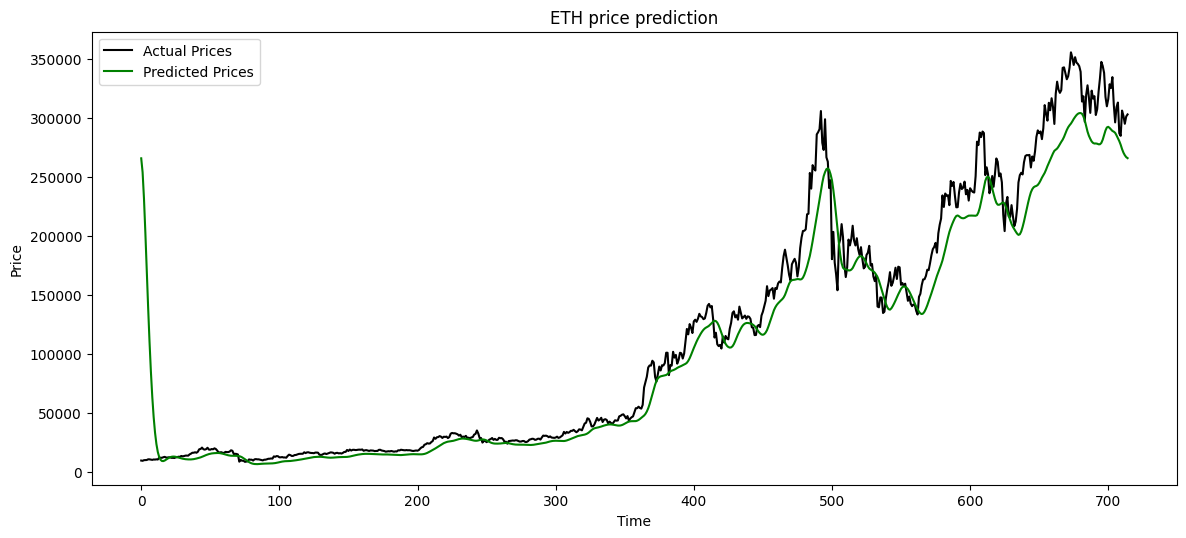

In [64]:
# Pridiction Prices and True Prices
plt.figure(figsize=(14, 6), dpi=100)
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()